In [3]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from tqdm import tqdm

pd.options.mode.chained_assignment = None

tickers = ['NVDA', 'AMZN', 'AAPL', 'TSLA', 'META', 'GOOG', 'MSFT', 'NFLX', 'DASH', 'UBER', 'ABNB', 'AMD']

def get_stock(tick):
    ticker = yf.Ticker(tick)
    stock_data = ticker.history(period="5y")
    stock_data = stock_data.reset_index(drop=False)
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.tz_localize(None)
    shares_outstanding = ticker.fast_info['market_cap'] / ticker.fast_info['lastPrice']
    stock_data['marketcap'] = stock_data['Close'] * shares_outstanding
    stock_data['stock_ticker'] = tick

    return stock_data

df_list = []
for t in tqdm(tickers):
    df_list.append(get_stock(t))

df = pd.concat(df_list, axis=0).reset_index(drop=True)
df.to_csv('stock_data_train.csv', index=False)
df

100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,marketcap,stock_ticker
0,2019-11-18,5.072578,5.307934,5.069593,5.281313,574588000,0.0,0.0,1.295506e+11,NVDA
1,2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,1.269325e+11,NVDA
2,2019-11-20,5.151692,5.337787,5.139004,5.253945,472588000,0.0,0.0,1.288793e+11,NVDA
3,2019-11-21,5.249467,5.305196,5.207422,5.229066,288388000,0.0,0.0,1.282690e+11,NVDA
4,2019-11-22,5.251705,5.298229,5.223095,5.246730,224100000,0.0,0.0,1.287023e+11,NVDA
...,...,...,...,...,...,...,...,...,...,...
14556,2024-11-11,147.380005,148.570007,144.910004,147.350006,29868100,0.0,0.0,2.461040e+11,AMD
14557,2024-11-12,147.000000,147.449997,141.550003,143.630005,33560300,0.0,0.0,2.398908e+11,AMD
14558,2024-11-13,142.860001,144.490005,139.070007,139.300003,35146600,0.0,0.0,2.326589e+11,AMD
14559,2024-11-14,140.339996,141.399994,138.559998,138.839996,31681400,0.0,0.0,2.318906e+11,AMD


In [7]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'marketcap', 'stock_ticker'],
      dtype='object')

In [9]:
N = 5
lag_feats = ['Open', 'High', 'Low', 'Close', 'Volume','marketcap']
feature_cols = []

def create_lag_features(group, N):
    group = group.copy()
    for i in range(1, N+1):
        for f in lag_feats:
            group[f'lag_{i}_{f}'] = group[f].shift(i)
            feature_cols.append(f'lag_{i}_{f}')
    group['target'] = group['Close'].shift(-1)  # Next day's close price
    return group

df_train = df.groupby('stock_ticker').apply(lambda group: create_lag_features(group, N))
df_train.dropna(inplace=True)


X = df_train[feature_cols]
y = df_train['target']

feature_cols

['lag_1_Open',
 'lag_1_High',
 'lag_1_Low',
 'lag_1_Close',
 'lag_1_Volume',
 'lag_1_marketcap',
 'lag_2_Open',
 'lag_2_High',
 'lag_2_Low',
 'lag_2_Close',
 'lag_2_Volume',
 'lag_2_marketcap',
 'lag_3_Open',
 'lag_3_High',
 'lag_3_Low',
 'lag_3_Close',
 'lag_3_Volume',
 'lag_3_marketcap',
 'lag_4_Open',
 'lag_4_High',
 'lag_4_Low',
 'lag_4_Close',
 'lag_4_Volume',
 'lag_4_marketcap',
 'lag_5_Open',
 'lag_5_High',
 'lag_5_Low',
 'lag_5_Close',
 'lag_5_Volume',
 'lag_5_marketcap',
 'lag_1_Open',
 'lag_1_High',
 'lag_1_Low',
 'lag_1_Close',
 'lag_1_Volume',
 'lag_1_marketcap',
 'lag_2_Open',
 'lag_2_High',
 'lag_2_Low',
 'lag_2_Close',
 'lag_2_Volume',
 'lag_2_marketcap',
 'lag_3_Open',
 'lag_3_High',
 'lag_3_Low',
 'lag_3_Close',
 'lag_3_Volume',
 'lag_3_marketcap',
 'lag_4_Open',
 'lag_4_High',
 'lag_4_Low',
 'lag_4_Close',
 'lag_4_Volume',
 'lag_4_marketcap',
 'lag_5_Open',
 'lag_5_High',
 'lag_5_Low',
 'lag_5_Close',
 'lag_5_Volume',
 'lag_5_marketcap',
 'lag_1_Open',
 'lag_1_High',


In [18]:
import random
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sample_size = int(len(tickers) * 0.8)
train_stocks = random.sample(tickers, sample_size)
test_stocks = [x for x in tickers if x not in train_stocks]
print('train_stocks', train_stocks)
print('test_stocks', test_stocks)
train = df_train[df_train['stock_ticker'].isin(train_stocks)]
test = df_train[df_train['stock_ticker'].isin(test_stocks)]

X_train = train[feature_cols]
y_train = train['target']

X_test = test[feature_cols]
y_test = test['target']

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

train_stocks ['TSLA', 'NVDA', 'AMD', 'NFLX', 'AAPL', 'AMZN', 'META', 'GOOG', 'UBER']
test_stocks ['MSFT', 'DASH', 'ABNB']
Test Mean Squared Error: 55.16938607320358


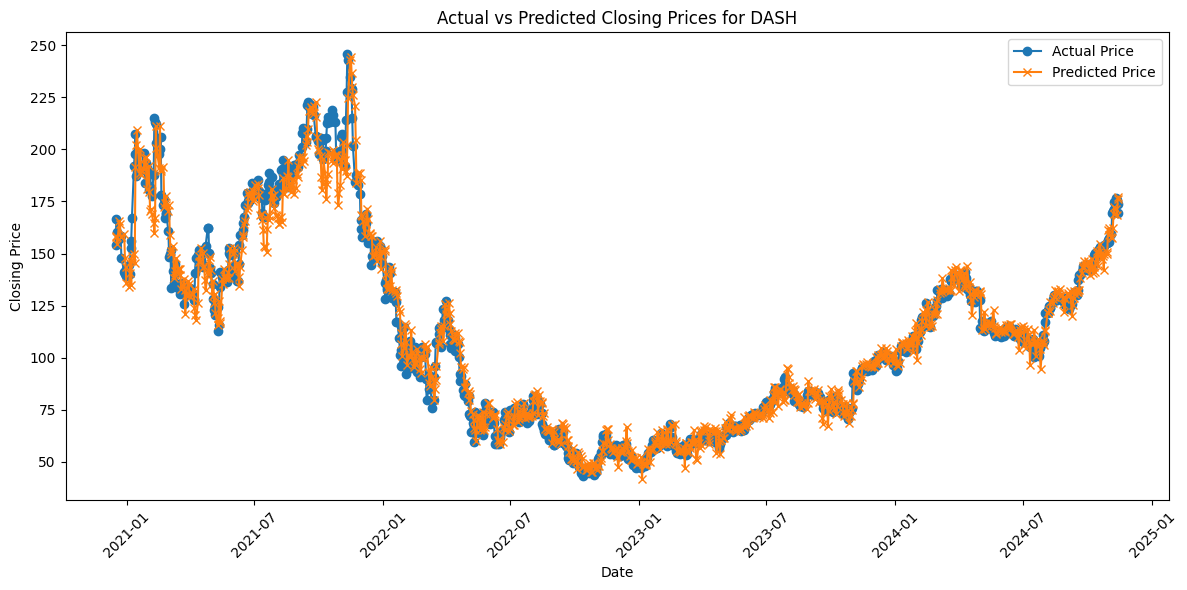

In [27]:
import matplotlib.pyplot as plt

plt_idx = 1

test2 = test.copy()
test2['y_pred'] = y_pred
test2 = test2[test2['stock_ticker']==test_stocks[plt_idx]]

plt.figure(figsize=(12, 6))
plt.plot(test2['Date'].tolist(), test2['target'].tolist(), label='Actual Price', marker='o')
plt.plot(test2['Date'].tolist(), test2['y_pred'].tolist(), label='Predicted Price', marker='x')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'Actual vs Predicted Closing Prices for {test_stocks[plt_idx]}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()